In [2]:
!pip install torchmetrics

  Using cached torchmetrics-0.9.0-py3-none-any.whl (418 kB)


In [39]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import pandas as pd
import numpy as np
import random
import collections
import csv
from sklearn.model_selection import train_test_split, KFold
from torch.optim import AdamW
from torchmetrics import Precision, F1Score
import matplotlib.pyplot as plt

In [40]:
def create_ancestors_dict(path_to_ancestors, path_to_weights=None):
    """_summary_

    Args:
        path_to_ancestors (string): path to the ancestors file
        path_to_weights (string, optional): path to the weight file. Defaults to None, uniform.

    Returns:
        dict: ancestors dict d[MESH][ancestors] for the ancestors list and d[MESH][proba] for the associated probabilities
    """

    ancestors_dict = collections.defaultdict(dict)

    # From ancestors csv file to dict
    ancestors = pd.read_csv(path_to_ancestors)
    pre_ancestors_dict = ancestors.groupby('MESH')['MESH_ANCESTOR'].apply(list).to_dict()

    # Create weight dict
    weights = dict()
    if path_to_weights:
        weights = pd.read_csv(path_to_weights).groupby("MESH")["TOTAL_PMID_MESH"].apply(int).to_dict()

    # browse ancestors and insert weights
    for mesh, ancestors in pre_ancestors_dict.items():

        # Add the MeSH itselft to the list of ancestors
        ancestors_dict[mesh]["ancestors"] = ancestors
        inverse_weights = [1/(weights.get(ancestor, 0) + 1) for ancestor in ancestors]
        ancestors_dict[mesh]["proba"] = [w/sum(inverse_weights) for w in inverse_weights]

    return ancestors_dict

In [41]:
ancestors_dict = create_ancestors_dict("data/mesh_ancestors.csv", "data/mesh_pmids_count.csv")
print(ancestors_dict["D010084"])

{'ancestors': ['D010084', 'D004734', 'D008660', 'D055598'], 'proba': [0.5175741161665298, 0.3766489956427783, 0.06788972626217674, 0.037887161928515004]}


In [42]:
def create_samples(n, data, w, ancestors, f_input, f_target):
    """
    n(int): nombre d'exemples à générer
    data(fichier format CSV): les pmids avec les mesh annotés
    w(int): taille de la fenêtre, nombre de meshs pour le contexte
    ancestors(dico {mesh:poids}): ancêtres du mesh dans arbre
    f_input(chemin fichier CSV): fichier où enregistrer le contexte
    f_target(chemin fichier CSV): fichier où enregistrer les target
    """
    
    context = []
    target = []
    
    df = pd.read_csv(data)
    pmids = [id for id in df["PMID"].unique()]

    i = 0
    while i < n:
        pmid = random.choice(pmids)
        mesh = df[df["PMID"] == pmid]["MESH"].to_list()

        # target = 1 mesh au hasard
        mesh_target = mesh.pop(random.randrange(len(mesh)))
        mesh_target = random.choices(ancestors[mesh_target]["ancestors"], weights=ancestors[mesh_target]["proba"], k=1)
        target.append(mesh_target)

        # contexte = w mesh au hasard
        if w > len(mesh):
            # supprimer
            target.pop()
        else:
            mesh_context = [mesh.pop(random.randrange(len(mesh))) for j in range(w)]
            mesh_context = [random.choices(ancestors[m]["ancestors"], weights=ancestors[m]["proba"], k=1)[0] for m in mesh_context]
            context.append(mesh_context)
            i += 1
            
    with open(f_input, "w") as f:
        write = csv.writer(f)
        write.writerows(context)
    with open(f_target, "w") as f:
        write = csv.writer(f)
        write.writerows(target)

In [43]:
create_samples(100000, "data/sample_pmid_mesh.csv", 6, ancestors_dict, "data/context.csv", "data/target.csv")

In [8]:
class MyDataset(Dataset):
    def __init__(self, context, target, vocab):
        """
        context(liste de liste): mesh du contexte
        target(liste): mesh cible
        vocab(dico {mesh:indice_du_1}) : indice du 1 pour le one shot vector qui représente le mesh
        """
        self.context = context
        self.target = target
        self.vocab = vocab
        
    def __len__(self):
        # taille vocab
        return len(self.target)
        
    def __getitem__(self, idx):
        if idx >= self.__len__():
            print("Error : index out of bounds")
            return None
            
        vector_target = np.zeros(len(self.vocab))
        vector_target[self.vocab[self.target[idx][0]]] = 1
        
        vector_context = np.zeros(len(self.vocab))
        for mesh in self.context[idx]:
            vector_context[self.vocab[mesh]] += 1
            
        return vector_context, vector_target
        

In [44]:
class MeSH2VecDataset(Dataset):
    """
    Create a Dataset for MeSH2VecDataset

    Args:
        f_input (str): path to the input file. A comma separated csv file where each line correspond to a context
        f_target (str): path to the target file. A csv file where each line correspond to target MeSH. Must be the same number of lines as in the context file.
        f_vocab (str): path to the vocabulary file. A csv file, one line by MeSH. The line number will five the id of the MeSH in the vocab.
        f_labels (str): path to the labels file. A two columns csv file, with MeSH identifier in the first column and the corresponding label in the second 

    Return: a list of two tensors: (tensor of length w corresponding to the context input ids, tensor of length 1 corresponding to the id of the target MeSH)
    """


    def __init__(self, f_input, f_target, f_vocab, f_labels):
        self.input = self.read(f_input).tolist()
        self.target = self.read(f_target).squeeze().tolist()
        self.vocab = self.read_vocab(f_vocab)
        self.inverse_vocab = {v: k for k, v in self.vocab.items()}
        self.vocab_size = len(self.vocab)
        self.labels = self.mesh2label_dict(f_labels)
        self.n = len(self.input)
        self.w = len(self.input[0])

    def __len__(self):
        return self.n

    def __getitem__(self, index):
        x = torch.tensor([self.vocab[m] for m in self.input[index]], dtype=torch.int32)
        y = torch.tensor(self.vocab[self.target[index]], dtype=torch.long)
        return x, y

    def read(self, path):
        f = pd.read_csv(path, header=None, dtype=str)
        return f.values

    def read_vocab(self, f_vocab):
        v = self.read(f_vocab).squeeze().tolist()

        # Check that all input are in vocab:
        flat_input = list(np.concatenate(self.input).flat)
        if not all([j in v for j in flat_input]):
            print("[WARNING] Some MeSH in input are not in the vocabulary")
        
        if not all([j in v for j in self.target]):
            print("[WARNING] Some MeSH in target are not in the vocabulary")
        
        return dict(zip(v, range(len(v))))

    def mesh2label_dict(self, f_labels):
        labels = self.read(f_labels)
        return dict(zip(labels[:, 0].tolist(), labels[:, 1].tolist()))
    
    def tensor2labels(self, t):
        return [self.labels.get(self.inverse_vocab.get(int(i), "NaN"), "No label Found") for i in t]


In [45]:
dataset = MeSH2VecDataset(f_input="data/context.csv", f_target="data/target.csv", f_vocab="data/mesh_vocab.csv", f_labels="data/mesh_labels.csv")

In [47]:
train, test = train_test_split(dataset, train_size=0.9, test_size=0.1, random_state=42)
print("Train : "+str(len(train)))
print("Test : "+str(len(test)))

kfold = KFold(5, shuffle=True, random_state=42)
for n, (train_i, validation_i) in enumerate(kfold.split(train)):
    print("Folder "+str(n))
    print("\tLen train : "+str(len(train_i)))
    print("\tLen test : "+str(len(validation_i)))
    
    train_sampler = SubsetRandomSampler(train_i)
    train_loader = DataLoader(train, 128, sampler=train_sampler)
    for i, j in enumerate(train_loader):
        print("\tTrain DataLoader "+str(i))
        print("\t\t["+str(j[0].shape)+"  "+str(j[1].shape)+"]")
        
    validation_sampler = SubsetRandomSampler(validation_i)
    validation_loader = DataLoader(train, 128, sampler=validation_sampler)
    for i, j in enumerate(validation_loader):
        print("\tTest DataLoader "+str(i))
        print("\t\t["+str(j[0].shape)+"  "+str(j[1].shape)+"]")

Train : 90000
Test : 10000
Folder 0
	Len train : 72000
	Len test : 18000
	Train DataLoader 0
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 1
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 2
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 3
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 4
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 5
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 6
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 7
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 8
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 9
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 10
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 11
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 12
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 13
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 14
		[tor

	Train DataLoader 240
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 241
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 242
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 243
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 244
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 245
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 246
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 247
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 248
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 249
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 250
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 251
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 252
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 253
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 254
		[torch.Size([128, 6])  torch.Size([128])]
	Train Dat

	Train DataLoader 562
		[torch.Size([64, 6])  torch.Size([64])]
	Test DataLoader 0
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 1
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 2
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 3
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 4
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 5
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 6
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 7
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 8
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 9
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 10
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 11
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 12
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 13
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 14
		[torch.Size([128, 6])  torch

	Train DataLoader 0
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 1
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 2
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 3
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 4
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 5
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 6
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 7
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 8
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 9
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 10
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 11
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 12
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 13
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 14
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 15
		[torch.Size(

	Train DataLoader 357
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 358
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 359
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 360
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 361
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 362
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 363
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 364
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 365
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 366
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 367
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 368
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 369
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 370
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 371
		[torch.Size([128, 6])  torch.Size([128])]
	Train Dat

	Test DataLoader 92
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 93
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 94
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 95
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 96
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 97
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 98
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 99
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 100
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 101
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 102
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 103
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 104
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 105
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 106
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 107
		[torch.Siz

	Train DataLoader 188
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 189
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 190
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 191
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 192
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 193
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 194
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 195
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 196
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 197
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 198
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 199
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 200
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 201
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 202
		[torch.Size([128, 6])  torch.Size([128])]
	Train Dat

	Train DataLoader 520
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 521
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 522
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 523
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 524
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 525
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 526
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 527
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 528
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 529
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 530
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 531
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 532
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 533
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 534
		[torch.Size([128, 6])  torch.Size([128])]
	Train Dat

	Train DataLoader 36
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 37
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 38
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 39
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 40
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 41
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 42
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 43
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 44
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 45
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 46
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 47
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 48
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 49
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 50
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 51
		[t

	Train DataLoader 389
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 390
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 391
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 392
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 393
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 394
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 395
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 396
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 397
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 398
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 399
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 400
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 401
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 402
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 403
		[torch.Size([128, 6])  torch.Size([128])]
	Train Dat

	Test DataLoader 122
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 123
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 124
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 125
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 126
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 127
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 128
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 129
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 130
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 131
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 132
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 133
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 134
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 135
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 136
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 137
		[t

	Train DataLoader 352
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 353
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 354
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 355
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 356
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 357
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 358
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 359
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 360
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 361
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 362
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 363
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 364
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 365
		[torch.Size([128, 6])  torch.Size([128])]
	Train DataLoader 366
		[torch.Size([128, 6])  torch.Size([128])]
	Train Dat

	Test DataLoader 78
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 79
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 80
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 81
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 82
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 83
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 84
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 85
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 86
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 87
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 88
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 89
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 90
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 91
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 92
		[torch.Size([128, 6])  torch.Size([128])]
	Test DataLoader 93
		[torch.Size([128, 

In [48]:
class NeuralNetwork(nn.Module):
    def __init__(self, n, v):
        """
        w(int): taille fenêtre
        n(int): taille embedding
        v(int): taille vocab
        """
        super(NeuralNetwork, self).__init__()
        self.n = n
        self.v = v
        self.hidden1 = nn.Embedding(self.v, self.n, max_norm = True)
        self.hidden2 = nn.Linear(self.n, self.v, bias = False)

    def forward(self, input):
        x = self.hidden1(input)
        x = torch.mean(x, axis = 1)
        x = self.hidden2(x)
        return x
        

In [50]:
def validation(model, validation_loader, loss_fn, device):
    n_classes = model.v
    total_loss = 0
    precision = 0
    f1_score = 0
    
    model.eval()
    
    m = nn.Softmax(dim=1)
    p = Precision(num_classes=n_classes, average="macro")
    f = F1Score(num_classes=n_classes, average="macro")
    
    for step, batch in enumerate(validation_loader):
        input = batch[0].to(device)
        target = batch[1].to(device)
        
        out = model(input)
        val_loss = loss_fn(out, target)
        total_loss += val_loss.item()
        
        proba = m(out)
        pred = torch.argmax(out, dim=1)
        
        precision += p(pred, target)
        
        f1_score += f(pred, target)
    
    mean_val_loss = total_loss / len(validation_loader)
    mean_precision = precision / len(validation_loader)
    mean_f1_score = f1_score / len(validation_loader)
    
    model.train()
    
    return mean_val_loss, mean_precision, mean_f1_score 

In [51]:
validation(model, validation_loader, loss_fn, DEVICE)

(9.454981168111166, tensor(0.), tensor(0.))

In [130]:
def training_loop(model, dataset_loader, validation_loader, optimizer, scheduler, loss_fn, nepochs, device):
    
    batch_train_errors = []
    batch_validation_errors = []
    batch_validation_precision = []
    batch_validation_f1 = []
    
    epoch_train_errors = []
    epoch_validation_errors = []
    epoch_validation_precision = []
    epoch_validation_f1 = []
    
    n_batch = 200

    #TODO init validation error

    for i in range(nepochs):
        print("Start epoch " + str(i + 1))

        # training mode
        model.train()
        
        batch_loss = 0
        batch_count = 0 
        total_loss = 0
        
        print("current learning rate: " + str(scheduler.get_last_lr()[0]))
        
        # Get data
        for step, batch in enumerate(dataset_loader):
            input = batch[0].to(device)
            target = batch[1].to(device)
            
            # Reinitiliyze grad
            model.zero_grad()

            # get model output for batch
            out = model(input)
            #print(out.shape)
            # Compute loss
            loss = loss_fn(out, target)

            # Update batch loss and total loss
            batch_loss += loss.item()
            batch_count += 1
            total_loss += loss.item()
            
            #TODO save batch loss at very n steps
            if step % n_batch == 0:
                print("batch number: " + str(step + 1))
                batch_train_errors.append(batch_loss / batch_count)
                batch_loss = 0
                batch_count = 0
                val_loss, val_precision, val_f1 = validation(model, validation_loader, loss_fn, device)
                batch_validation_errors.append(val_loss)
                batch_validation_precision.append(val_precision)
                batch_validation_f1.append(val_f1)
                print(f"train loss: {batch_train_errors[-1]:.3f}\tvalidation loss: {batch_validation_errors[-1]:.3f}")
                
            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
        
        scheduler.step()
            
        epoch_train_errors.append(total_loss / len(dataset_loader))
        
        val_loss, val_precision, val_f1 = validation(model, validation_loader, loss_fn, device)
        epoch_validation_errors.append(val_loss)
        epoch_validation_precision.append(val_precision)
        epoch_validation_f1.append(val_f1)
        
    return {"batch_train_errors": batch_train_errors, 
            "batch_validation_errors": batch_validation_errors,
            "batch_validation_precision": batch_validation_precision,
            "batch_validation_f1": batch_validation_f1,
            "epoch_train_errors": epoch_train_errors,
            "epoch_validation_errors": epoch_validation_errors,
            "epoch_validation_precision": epoch_validation_precision,
            "epoch_validation_f1": epoch_validation_f1}
    

In [131]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [132]:
lambda1 = lambda epoch: 0.85 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

lrs = []

for i in range(10):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
#     print("Factor = ", round(0.65 ** i,3)," , Learning Rate = ",round(optimizer.param_groups[0]["lr"],3))
    scheduler.step()
    print(scheduler.get_last_lr())

[0.02125]
[0.0180625]
[0.015353124999999999]
[0.013050156249999998]
[0.0110926328125]
[0.009428737890624999]
[0.008014427207031249]
[0.0068122631259765615]
[0.005790423657080077]
[0.004921860108518065]


No GPU available, using the CPU instead.


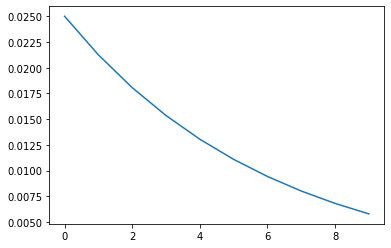

In [133]:
set_seed(1024)

# Split train / test
train, test = train_test_split(dataset, train_size=0.9, test_size=0.1, random_state=42)

# KFolding
kfold = KFold(5, shuffle=True, random_state=42)
train_index, validation_index = next(iter(kfold.split(train)))

train_sampler = SubsetRandomSampler(train_index)
dataset_loader = DataLoader(train, 128, sampler=train_sampler)

validation_sampler = SubsetRandomSampler(validation_index)
validation_loader = DataLoader(train, 128, sampler=validation_sampler)

# set number of epoch
nepochs = 30

# Set optimizer
optimizer = AdamW(model.parameters(),
    lr=0.025,    # Default learning rate
    eps=1e-8    # Default epsilon value
    )

# Set scheduler
lambda1 = lambda epoch: 0.85 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

plt.plot(range(10),lrs)

loss_fn = nn.CrossEntropyLoss()
DEVICE = None

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    DEVICE = torch.device("cpu")

In [134]:
vocab_size = dataset.vocab_size
model = NeuralNetwork(50, vocab_size)

In [ ]:
dico = training_loop(model, dataset_loader, validation_loader, optimizer, scheduler, loss_fn, nepochs, DEVICE)

Start epoch 1
current learning rate: 0.025
batch number: 1
train loss: 9.454	validation loss: 9.454
batch number: 201
train loss: 9.454	validation loss: 9.454
batch number: 401
train loss: 9.454	validation loss: 9.454
Start epoch 2
current learning rate: 0.02125
batch number: 1
train loss: 9.455	validation loss: 9.454
batch number: 201
train loss: 9.454	validation loss: 9.454
batch number: 401
train loss: 9.454	validation loss: 9.454
Start epoch 3
current learning rate: 0.0180625
batch number: 1


In [61]:
print(dico)

{'batch_train_errors': [9.455053329467773, 6.856465899944306, 4.774632604122162, 3.512253999710083, 3.733698880672455, 3.583004114627838, 3.4392127990722656, 3.4261470007896424, 3.382089771032333, 3.2832112312316895, 3.289222236871719, 3.270563784837723, 3.2052502632141113, 3.188423743247986, 3.17301124215126, 2.999422073364258, 3.0853746914863587, 3.0779147756099703, 2.849256753921509, 2.988705642223358, 2.991427673101425, 3.1666102409362793, 2.9128298962116244, 2.9017292058467863, 2.7046432495117188, 2.8287294471263884, 2.8230351316928863, 2.7677433490753174, 2.7535062623023987, 2.776449154615402], 'batch_validation_errors': [9.454800396100849, 5.4868165787230145, 4.257197850139429, 3.8716597827613777, 3.65991699103768, 3.539519705670945, 3.475908654801389, 3.422257514710122, 3.366004275937452, 3.338621898745814, 3.3041913847551276, 3.2651457668196224, 3.2411473372303847, 3.2053918703228024, 3.175161464839962, 3.14728375022293, 3.122314823434708, 3.083251515178816, 3.068309447444077,

In [56]:
print(len(dataset))

100000


In [57]:
print(len(dataset_loader))
print(len(validation_loader))

563
141


Text(0.5, 0.98, 'Errors')

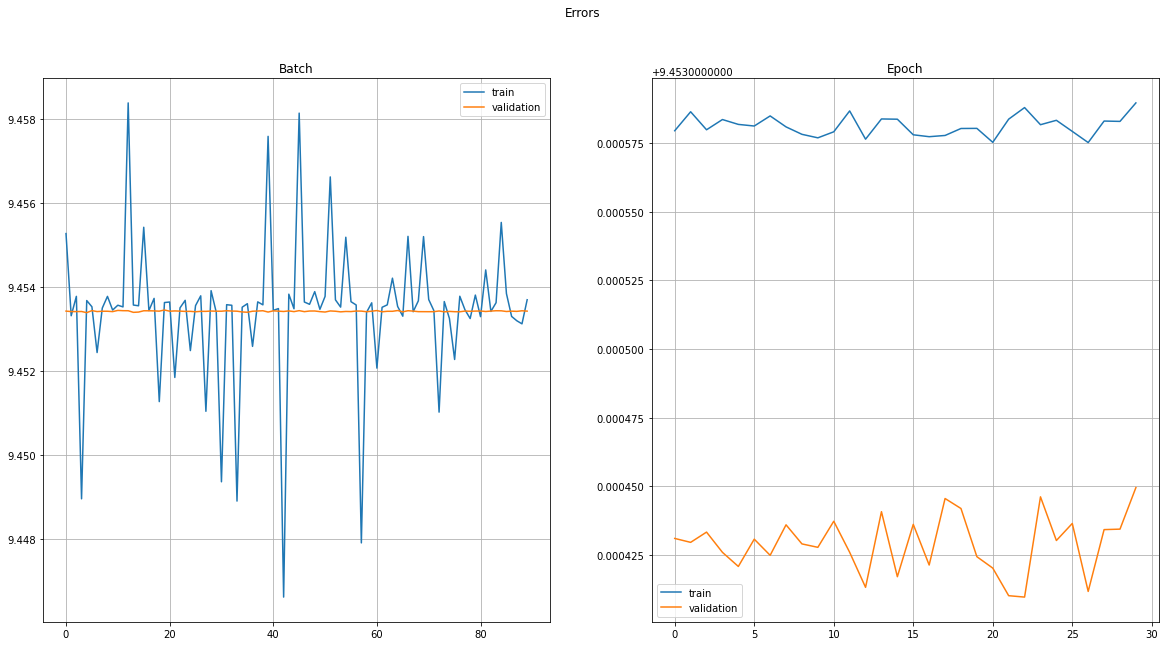

In [125]:
# Errors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.plot(range(len(dico["batch_train_errors"])), dico["batch_train_errors"], label="train")
ax1.plot(range(len(dico["batch_validation_errors"])), dico["batch_validation_errors"], label="validation")
ax1.set_title("Batch")
ax1.legend()
ax1.grid()

ax2.plot(range(nepochs), dico["epoch_train_errors"], label="train")
ax2.plot(range(nepochs), dico["epoch_validation_errors"], label="validation")
ax2.set_title("Epoch")
ax2.legend()
ax2.grid()

fig.suptitle("Errors")

Text(0.5, 0.98, 'Errors')

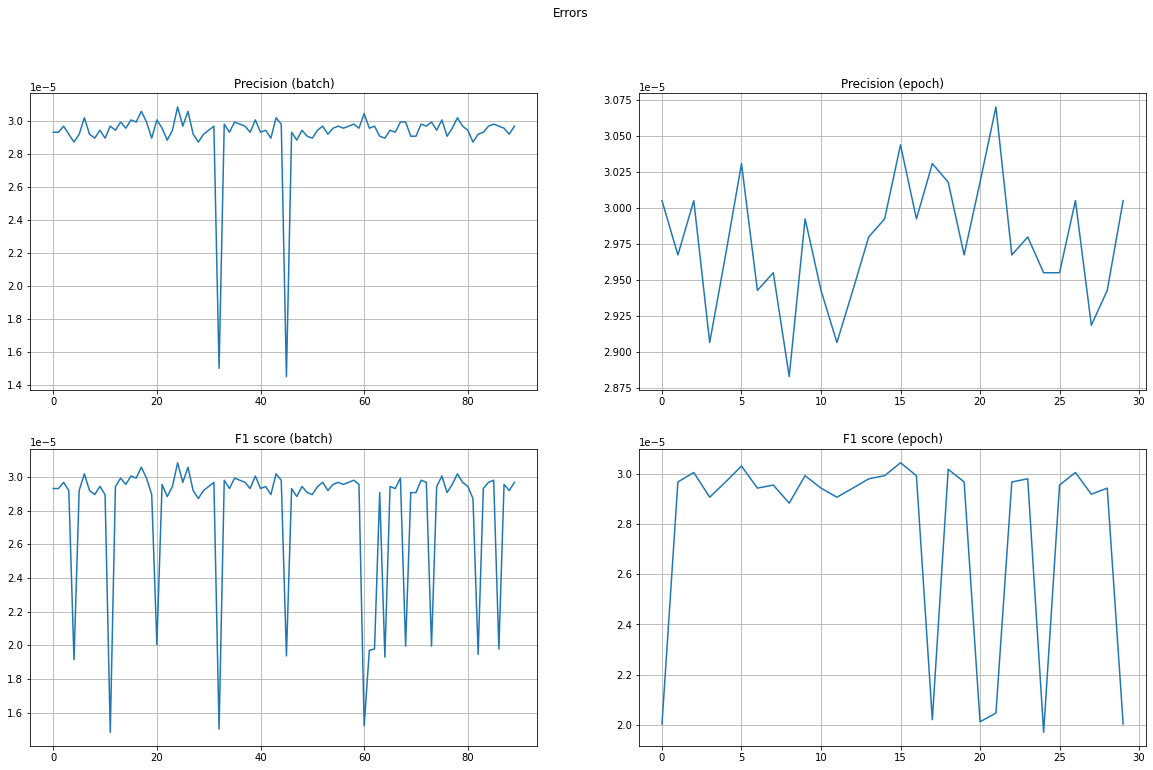

In [126]:
# Precision et F1 score
fig, axs = plt.subplots(2, 2, figsize=(20,12))

axs[0, 0].plot(range(len(dico["batch_validation_precision"])), dico["batch_validation_precision"])
axs[0, 0].set_title("Precision (batch)")
axs[0, 0].grid()

axs[0, 1].plot(range(nepochs), dico["epoch_validation_precision"])
axs[0, 1].set_title("Precision (epoch)")
axs[0, 1].grid()

axs[1, 0].plot(range(len(dico["batch_validation_f1"])), dico["batch_validation_f1"])
axs[1, 0].set_title("F1 score (batch)")
axs[1, 0].grid()

axs[1, 1].plot(range(nepochs), dico["epoch_validation_f1"])
axs[1, 1].set_title("F1 score (epoch)")
axs[1, 1].grid()

fig.suptitle("Errors")

In [96]:
test_loader = DataLoader(test, 128)
validation(model, test_loader, loss_fn, DEVICE)

(2.303176457368875, tensor(0.2431), tensor(0.2448))

In [63]:
def save_model(model, f_model):
    """
    model: neural network
    f_model : format .pth
    """
    torch.save(model, f_model)

In [64]:
def load_model(f_model):
    """
    f_model : format .pth
    """
    return torch.load(f_model)

In [65]:
save_model(model, "data/model.pth")